### 用管道的方法简化工作流

In [31]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 使用威斯康辛的乳腺癌的数据
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
from sklearn.preprocessing import LabelEncoder  # 将分类数据转换为数值数据
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [5]:
from sklearn.model_selection import train_test_split#数据分为测试集合训练集
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# 一整个流程形成一个管道
pipe_lr = make_pipeline(StandardScaler(), PCA(
    n_components=2), LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
pipe_lr.predict(X_test)
pipe_lr.score(X_test, y_test)

0.956140350877193

### 使用抵抗交叉验证评估模型

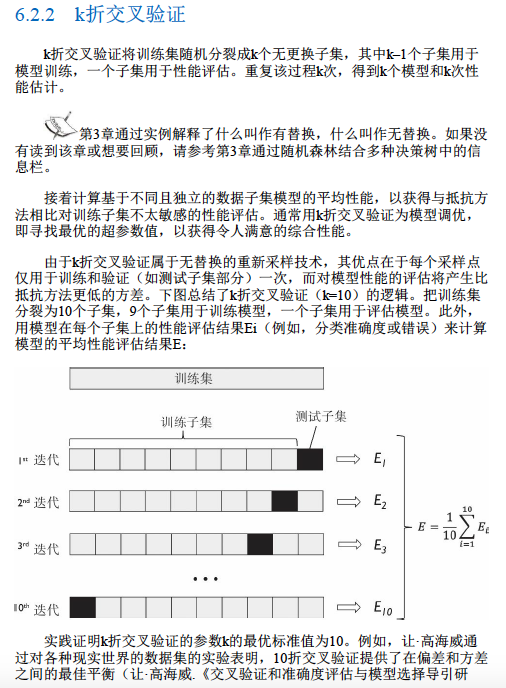

In [7]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f ' %
          (k+1, np.bincount(y_train[train]), score))
print('\nCV accuracy: %.3f +- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935 
Fold:  2, Class dist.: [256 153], Acc: 0.935 
Fold:  3, Class dist.: [256 153], Acc: 0.957 
Fold:  4, Class dist.: [256 153], Acc: 0.957 
Fold:  5, Class dist.: [256 153], Acc: 0.935 
Fold:  6, Class dist.: [257 153], Acc: 0.956 
Fold:  7, Class dist.: [257 153], Acc: 0.978 
Fold:  8, Class dist.: [257 153], Acc: 0.933 
Fold:  9, Class dist.: [257 153], Acc: 0.956 
Fold: 10, Class dist.: [257 153], Acc: 0.956 

CV accuracy: 0.950 +- 0.014


/Users/apple/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [8]:
# sklearn的交叉验证得分器
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train,
                         y=y_train, cv=10, n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('\nCV accuracy: %.3f +- %.3f' % (np.mean(scores), np.std(scores)))

# cross_val_score方法极为有用的功能是可以把不同分区的评估任务分给计算机的多个CPU。假设把n_jobs设为1，只有一个CPU会用于性能评估，
# 就像前面StratifiedKFold示例展示的那样。然而，如果设置n_jobs=2，可以把10轮交叉验证任务分给两个CPU来完成（如果系统有那么多CPU的话），
# 如果设置n_jobs=-1，可以用计算机上所有可用的CPU同时进行计算。

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]

CV accuracy: 0.950 +- 0.014


### 用学习曲线诊断偏差和方差问题

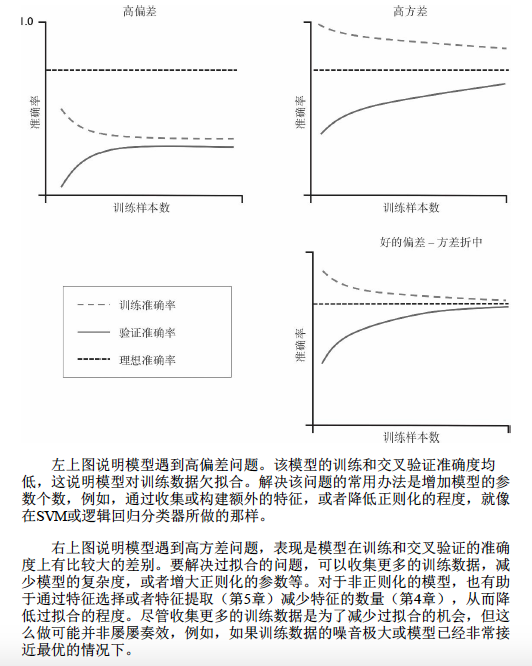

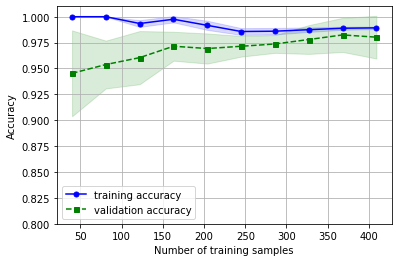

In [9]:
#用学习曲线来评估模型
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr=make_pipeline(StandardScaler(),LogisticRegression(penalty='l2',random_state=1))
train_sizes,train_scores,test_scores=learning_curve(estimator=pipe_lr,
                                                              X=X_train,y=y_train,
                                                              train_sizes=np.linspace(0.1,1,10),#0.1到1分10个,样本量不断增加，每个样本量内都用十折交叉验证
                                                             cv=10,n_jobs=1 )
train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean,color='blue',marker='o',
        markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,
                alpha=0.15,color='blue')
plt.plot(train_sizes,test_mean,color='green',marker='s',linestyle='--',
        markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,
                alpha=0.15,color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.ylim([0.8,1.01])
plt.show()

##### 正如在前面的学习曲线图中所看到的，如果模型在训练中见过250多个样本，那么该模型在训练和验证数据集上表现均好。可以看到，对于样本规模少于250的训练集，模型的训练准确度提高，验证和训练准确度之间的差距扩大，是过拟合程度越来越大的标志。

### 用验证曲线解决过拟合和欠拟合的问题

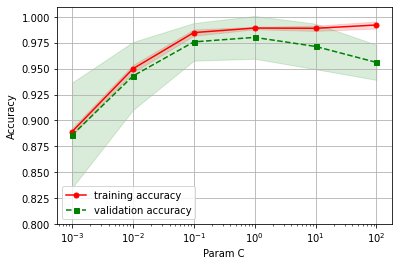

In [34]:
from sklearn.model_selection import validation_curve
pipe_lr = make_pipeline(
    StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
param_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train, y=y_train,
                                             param_range=param_range,
                                             param_name='logisticregression__C',  # 双下划线
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='red', marker='o',
         markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std,
                 alpha=0.15, color='red')
plt.plot(param_range, test_mean, color='green', marker='s', linestyle='--',
         markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Param C')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.ylim([0.8, 1.01])
plt.show()

### 通过网格搜索为模型调优

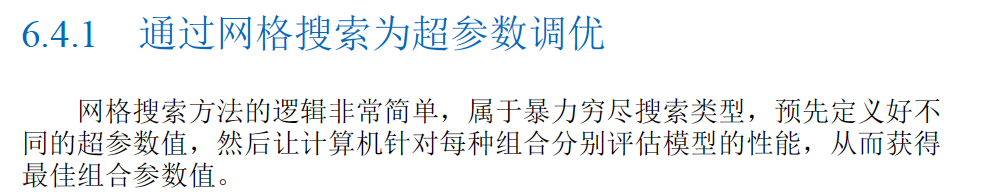

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svm = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range,  'svc__gamma':param_range,'svc__kernel': ['rbf']}]
gs=GridSearchCV(estimator=pipe_svm,
               param_grid=param_grid,
               scoring='accuracy',
               cv=10,
               n_jobs=-1)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [41]:
clf=gs.best_estimator_
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.9736842105263158

### 用嵌套交叉验证来选择算法

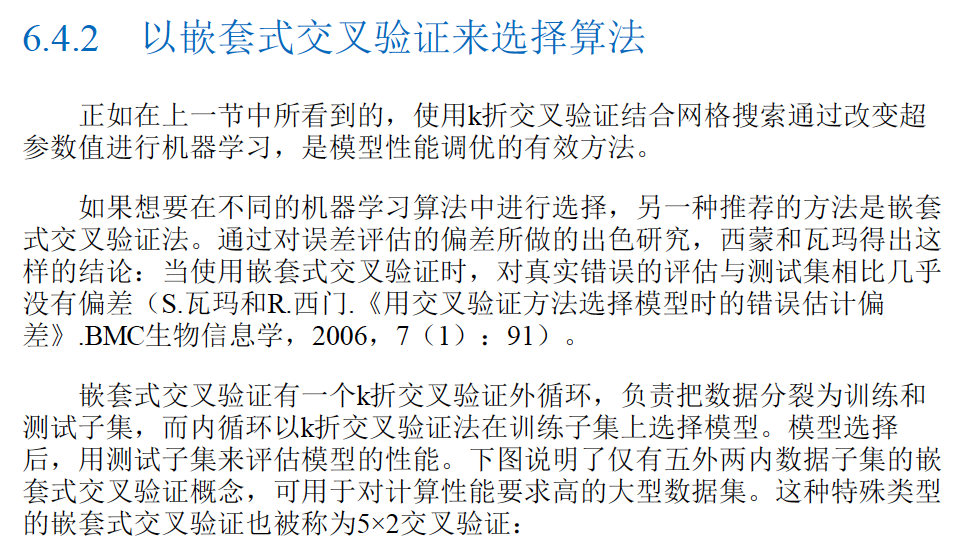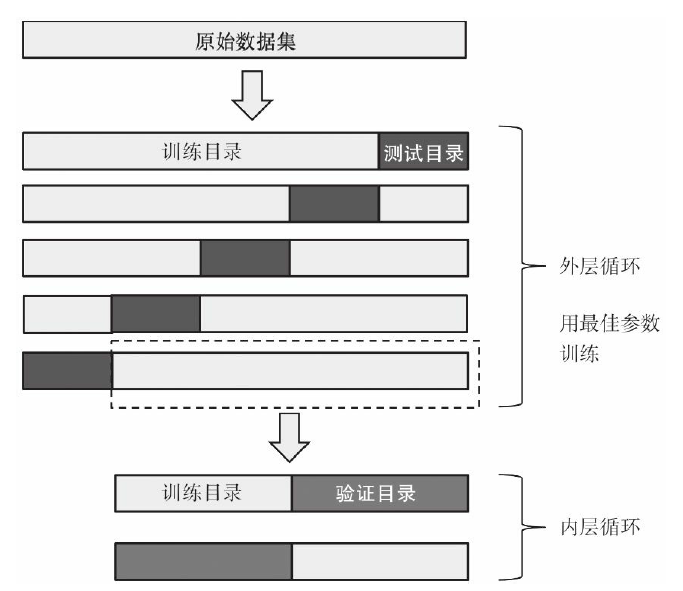

In [42]:
scores=cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [43]:
from sklearn.tree import DecisionTreeClassifier
gs=GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
               param_grid=[{'max_depth':[1,2,3,4,5,6,None]}],
               scoring='accuracy',
               cv=2)
scores=cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
#决策数的效能要差一些

CV accuracy: 0.938 +/- 0.016


### 比较不同性能评估的差异

In [44]:
from sklearn.metrics import confusion_matrix
pipe_svm.fit(X_train,y_train)
y_pred=pipe_svm.predict(X_test)
confmat=confusion_matrix(y_true=y_test,y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


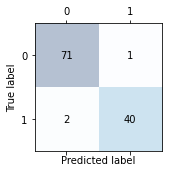

In [45]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

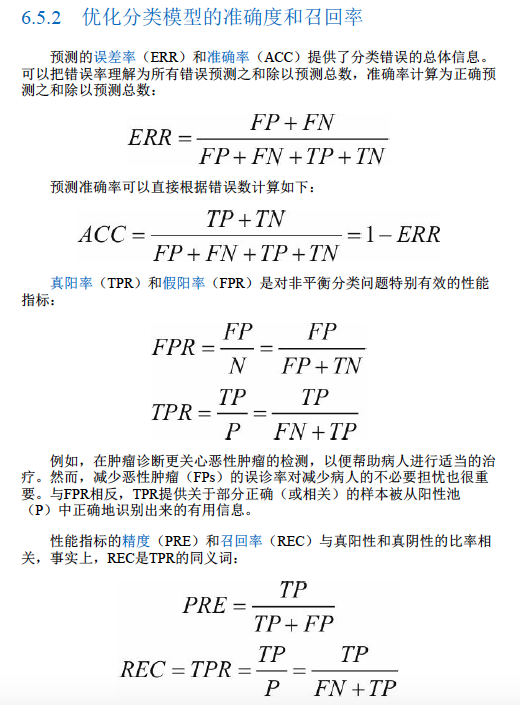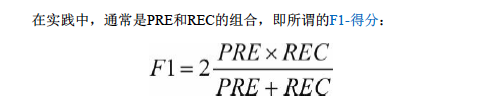

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [48]:
from sklearn.metrics import make_scorer
scorer = make_scorer(f1_score, pos_label=0)  # 构建自己的评分器，，阳性取0

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svm,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### ROC曲线

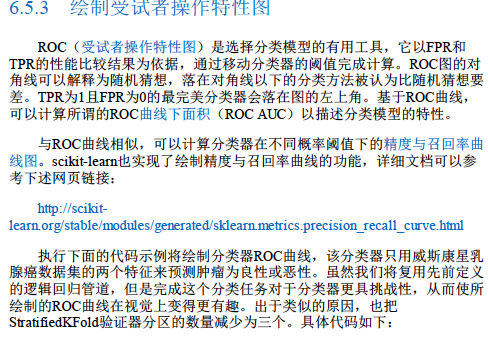

56
100
53
100
56
100


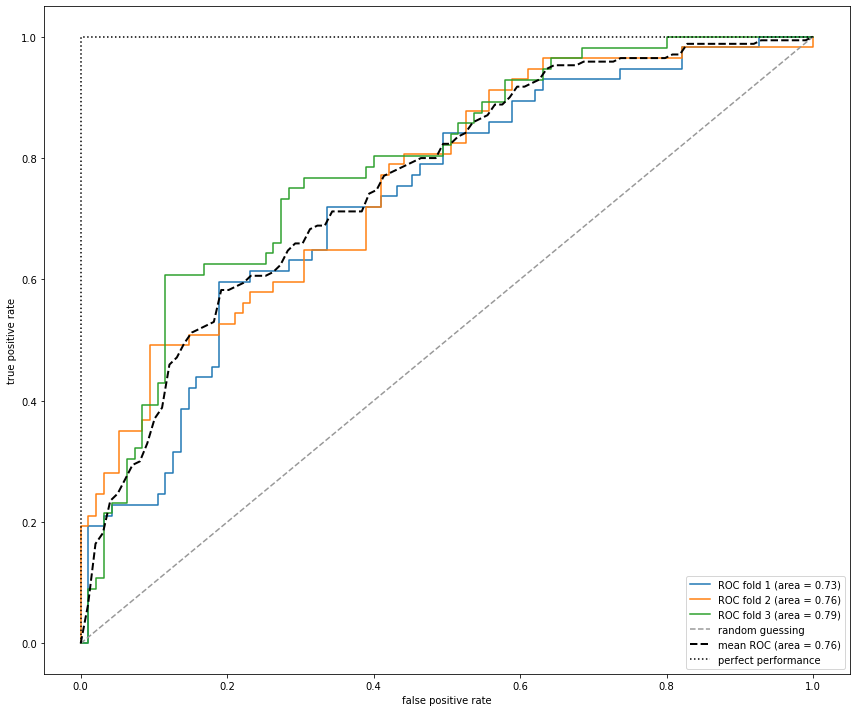

In [64]:
from sklearn.metrics import roc_curve,auc#计算roc曲线下方的面积
from scipy import interp
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]#把这两个因子拿出来
    

cv = list(StratifiedKFold(n_splits=3, 
                          random_state=1).split(X_train, y_train))#3折交叉验证

fig = plt.figure(figsize=(12, 10))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)#插值，因为每次交叉验证的个数没有总体的那么多
    print(len(tpr))
    print(len(mean_tpr))
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)#计算面积
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))#画出每折交叉验证的图

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

In [65]:
# 多元分类评分指标，取均值

pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')

### 处理类的不平衡问题

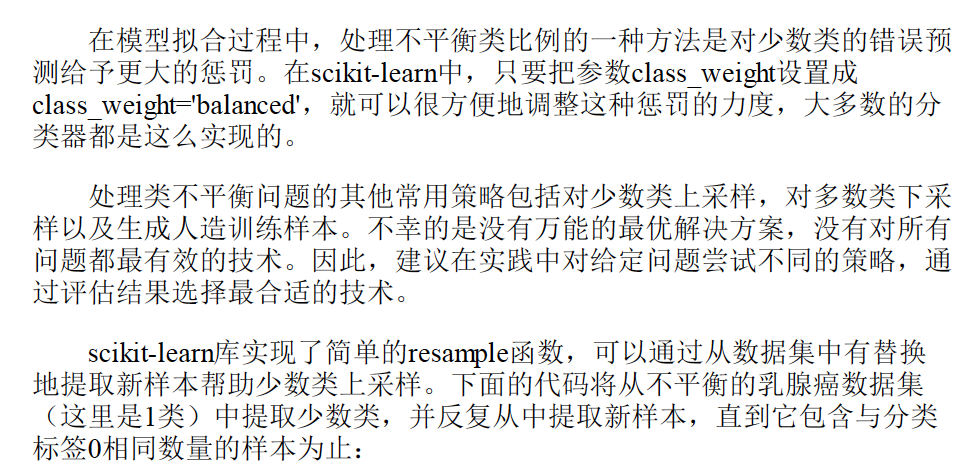

In [68]:
from sklearn.utils import resample#对少数类进行重采样
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100
print('Number of class 1 samples before:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('Number of class 1 samples after:', X_upsampled.shape[0])

Number of class 1 samples before: 40
Number of class 1 samples after: 357


In [69]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

本章的开头讨论了如何在方便的模型管道中连接不同的转换技术和分类
器，从而更有效地训练和评估机器学习模型。然后用这些管道进行k折交叉验证，这是一种模型选择和评价的基本方法。用k折交叉验证绘制学习曲线来诊断学习算法中的常见问题，如过拟合和欠拟合。可以用网格搜索进一步对模型的参数调优。我们以介绍含混矩阵和各种性能评价指标结束本章，这些指标对于进一步优化模型和解决特定问题很有用。现在我们已经掌握了必要的技术来为成功分类建立有监督的机器学习模型。